In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image
import numpy as np
from matplotlib import pyplot

In [2]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,3):
        for j in range(0,3):
            pyplot.subplot2grid((3,3),(i,j))
            pyplot.imshow(X[k])
            k = k+1
    pyplot.show()


# EDA

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

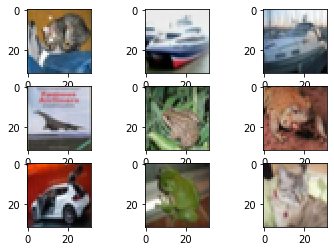

In [4]:
#visualise test data
show_imgs(x_test[:9])

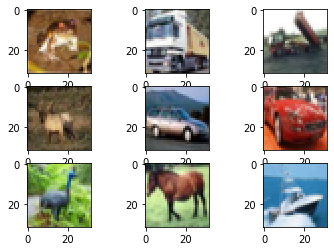

In [5]:
#visualise training data
show_imgs(x_train[:9])

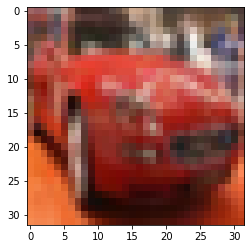

In [6]:
pyplot.imshow(x_train[5])

In [7]:
print('X train: ' , x_train.shape)
print('Y train: ' , y_train.shape)
print('X test: ', x_test.shape)
print('Y test: ', y_test.shape)

X train:  (50000, 32, 32, 3)
Y train:  (50000, 1)
X test:  (10000, 32, 32, 3)
Y test:  (10000, 1)


# Preprocessing

In [8]:
#data augmentation and normalization

from keras.preprocessing.image import ImageDataGenerator

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#mean = np.mean(x_train,axis=(0,1,2,3))
#std = np.std(x_train,axis=(0,1,2,3))
#x_train = (x_train-mean)/(std+1e-7)
#x_test = (x_test-mean)/(std+1e-7)
x_train = x_train/255
x_test = x_test/255

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

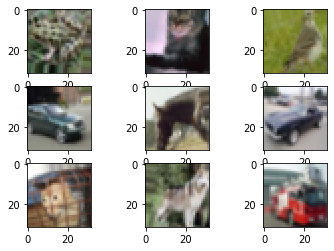

In [9]:
#visualise augmented and normalised training images

from matplotlib import pyplot as plt

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=True):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(32, 32, 3))
    plt.show()
    break

In [10]:
print('Labels:' , np.unique(y_train))

Labels: [0 1 2 3 4 5 6 7 8 9]


In [11]:
#one hot encode target variable

num_classes = 10
y_train = utils.to_categorical(y_train,num_classes)
y_test = utils.to_categorical(y_test,num_classes)

In [12]:
y_test[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

# Model

In [13]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [14]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
model = Sequential()
model.add(layers.UpSampling2D((2,2), input_shape=x_train.shape[1:]))
model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['acc'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               5

In [17]:
#train
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), verbose=1, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
782/782 [==============================] - 200s 255ms/step - loss: 0.9641 - acc: 0.6844 - val_loss: 2.2085 - val_acc: 0.2947
Epoch 2/2
782/782 [==============================] - 201s 258ms/step - loss: 0.4441 - acc: 0.8554 - val_loss: 0.3124 - val_acc: 0.8987


In [18]:
#train
history1 = model.fit(datagen.flow(x_train, y_train, batch_size=64), verbose=1, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
782/782 [==============================] - 201s 257ms/step - loss: 0.3240 - acc: 0.8926 - val_loss: 0.2466 - val_acc: 0.9211
Epoch 2/2
782/782 [==============================] - 201s 257ms/step - loss: 0.2570 - acc: 0.9163 - val_loss: 0.2301 - val_acc: 0.9279


In [21]:
#train
history2 = model.fit(datagen.flow(x_train, y_train, batch_size=64), verbose=1, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
782/782 [==============================] - 201s 257ms/step - loss: 0.2139 - acc: 0.9300 - val_loss: 0.2086 - val_acc: 0.9342
Epoch 2/2
782/782 [==============================] - 201s 257ms/step - loss: 0.1799 - acc: 0.9410 - val_loss: 0.2151 - val_acc: 0.9344


In [22]:
#test
model.evaluate(x_test, y_test)

313/313 [==============================] - 12s 39ms/step - loss: 0.2151 - acc: 0.9344


[0.21511110663414001, 0.9344000220298767]

In [23]:
model.save('model.h5')

# Load Saved Model and Predict

In [24]:
# reload model
model = tf.keras.models.load_model('model.h5')
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['acc'])

In [25]:
x = np.argmax(model.predict(x_test[0:10000]),1)

In [26]:
#frequency count for each predicted class
np.array(np.unique(x, return_counts=True)).T

array([[   0, 1020],
       [   1, 1035],
       [   2,  980],
       [   3,  969],
       [   4, 1041],
       [   5,  900],
       [   6, 1063],
       [   7,  999],
       [   8, 1011],
       [   9,  982]], dtype=int64)

In [27]:
predictions = x[7000:7009]

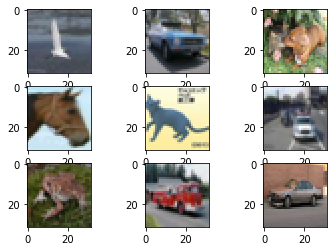

Predicted:  ['ship', 'automobile', 'frog', 'horse', 'cat', 'automobile', 'frog', 'truck', 'automobile']
True Labels:  ['bird', 'automobile', 'cat', 'horse', 'cat', 'automobile', 'frog', 'truck', 'automobile']


In [28]:
#visualise test results

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

show_imgs(x_test[7000:7009])
 
#true value of labels
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#indices = np.argmax(model.predict(x_test[7000:7009]),1)
print ('Predicted: ', [labels[x] for x in predictions])

val = []
for x in y_test[7000:7009]:
    val.append(x[0])
print('True Labels: ', [labels[x] for x in val])

# Analyze Permormance

In [29]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df = hist_df.append(pd.DataFrame(history1.history))
hist_df = hist_df.append(pd.DataFrame(history2.history))

In [30]:
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 1
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   loss      6 non-null      float64
 1   acc       6 non-null      float64
 2   val_loss  6 non-null      float64
 3   val_acc   6 non-null      float64
dtypes: float64(4)
memory usage: 240.0 bytes


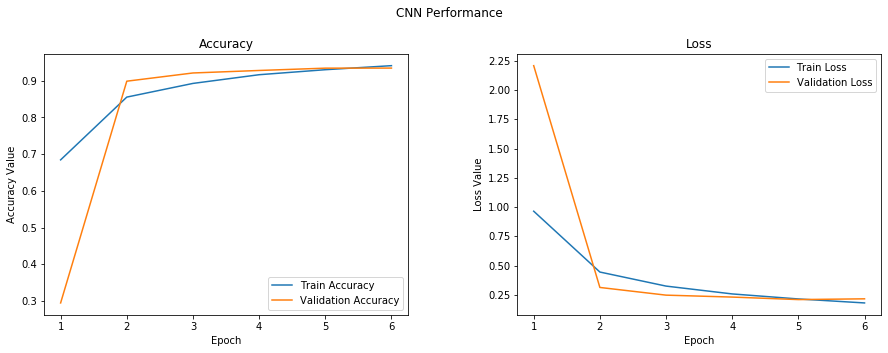

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,6+1))
ax1.plot(epochs, hist_df['acc'], label='Train Accuracy')
ax1.plot(epochs, hist_df['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, hist_df['loss'], label='Train Loss')
ax2.plot(epochs, hist_df['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")